# **GUNITA - Programming Assignment 4**
<h2>Support Vector Machine</h2>

# Installation of Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectFromModel

## Loading the Dataset

In [2]:
# X contains features, while y contains labels
data = load_breast_cancer()
x, y = data.data, data.target

We limited the features to include only the mean values, which greatly decreases training and inference time while also reducing memory usage. Additionally, having fewer features simplifies exploratory data analysis, making the process more efficient and less complex.

In [3]:
# Index the dataset
x = x[:, :10]

# Exploratory Data Analysis

To perform EDA, we have to change x from an `numpy.ndarray` to a `pandas.DataFrame` with the proper feature names to visualize it better.

In [4]:
x_df = pd.DataFrame(x, columns=data.feature_names[:10])
x_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


Checking for missing values.

In [5]:
x_df.isnull().sum()

mean radius               0
mean texture              0
mean perimeter            0
mean area                 0
mean smoothness           0
mean compactness          0
mean concavity            0
mean concave points       0
mean symmetry             0
mean fractal dimension    0
dtype: int64

Since we have already trained a logistic regression model on this breast cancer dataset, the same exploratory data analysis (EDA) applies, as we are working with the same dataset and task. A pairplot would generate 100 plots, making it excessively large and difficult to analyze. Therefore, we opted for a heatmap to numerically visualize the correlations between variables.

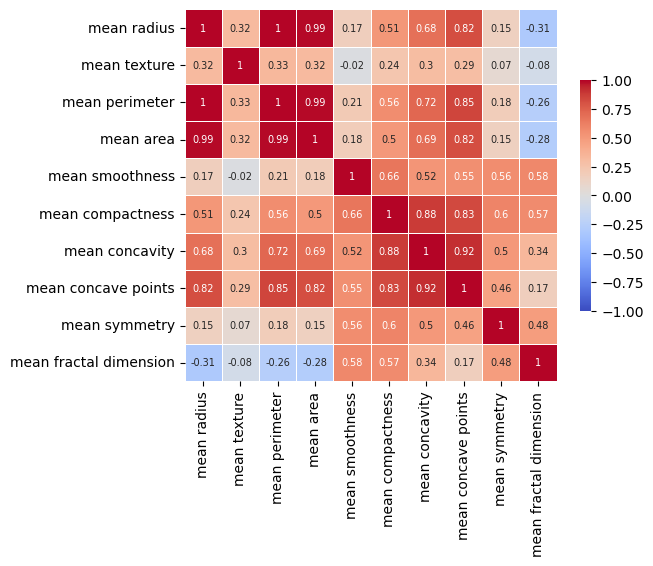

In [6]:
def heatmap(x):
  corr = x.corr().round(2)
  f, ax = plt.subplots(figsize=(6, 6))
  cmap = sns.diverging_palette(220, 10, as_cmap=True)
  sns.heatmap(corr, cmap='coolwarm', vmin=-1, vmax=1, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, annot_kws={"fontsize":7})
  plt.show()

heatmap(x_df)

From this, we can observe strong linear correlations among certain features, which may lead to multicollinearity issues, ultimately reducing the effectiveness of any model we use. To address this, it is beneficial to remove some of these features. It is evident that radius, perimeter, and area are highly collinear, so we retain the radius parameter since it inherently represents both perimeter and area. Additionally, concavity, symmetry, and compactness also exhibit high collinearity, making a strong case for their removal as well.

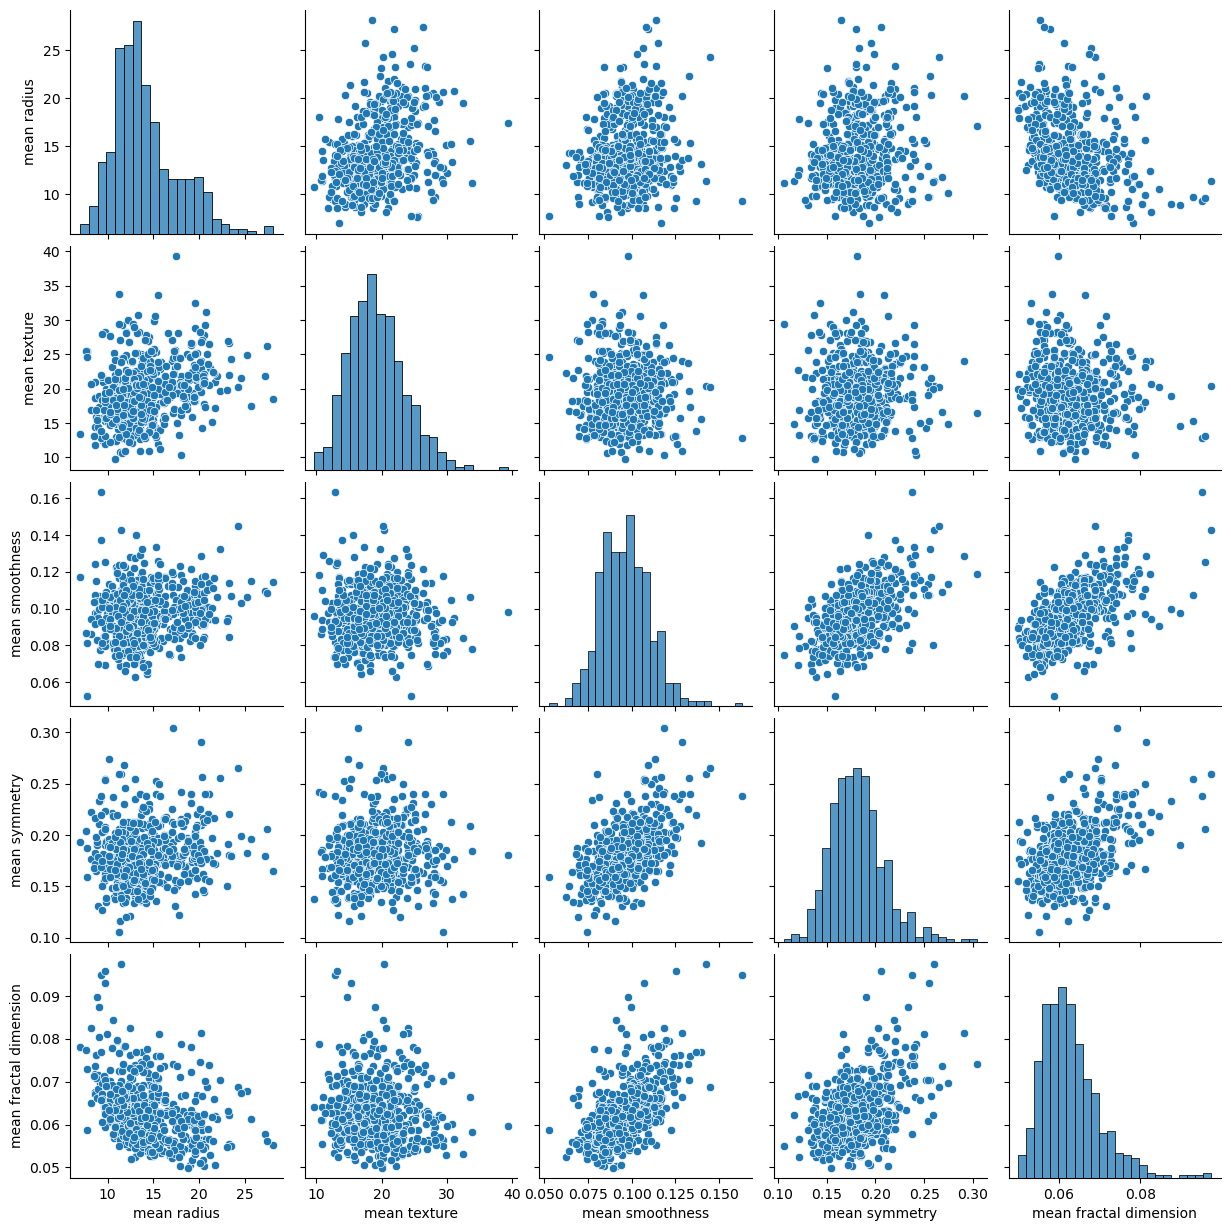

In [7]:
r = x_df.iloc[:, [0, 1, 4, 8, 9]]
sns.pairplot(r);

With reduced number of features, we can now use `sns.pairplot` to see any trends among the chosen features. We can also see that the values are distributed in a Gaussian distribution. We can use the `StandardScaler` to normalize this distribution for better training stability.

In [8]:
x = r.to_numpy()
x.shape

(569, 5)

# Model Training

Split the dataset into 70% training and 30% testing sets. We stratified across the labels to make sure there are enough data points for both labels.

In [9]:
# Stratify the dataset across y
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)

Normalize the feature values using `StandardScaler`.

In [10]:
# Normalize features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

Train the Support Vector Classifier with the default parameters.

In [11]:
# Fit model
svm = SVC()
svm.fit(x_train, y_train)

SVC()

From the given evaluation metrics, we can see that there seems to be overfitting. The testing accuracy is too far from the training accuracy which may need a bit of regularization to fix.

# Model Evaluation

In [12]:
# Evaluate initial model
train_acc = accuracy_score(y_train, svm.predict(x_train))
test_acc = accuracy_score(y_test, svm.predict(x_test))
print(f"Initial Training Accuracy: {train_acc:.4f}")
print(f"Initial Testing Accuracy: {test_acc:.4f}")

Initial Training Accuracy: 0.9623
Initial Testing Accuracy: 0.9123


In [13]:
from sklearn.model_selection import StratifiedKFold

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly']
}

stkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(SVC(), param_grid, cv=stkfold, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_train, y_train)

# Best parameters and retraining
best_svm = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")
best_svm.fit(x_train, y_train)

Best Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


SVC(C=10, gamma=0.1)

In [14]:
# Final evaluation
train_acc = accuracy_score(y_train, best_svm.predict(x_train))
test_acc = accuracy_score(y_test, best_svm.predict(x_test))
print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Testing Accuracy: {test_acc:.4f}")

Final Training Accuracy: 0.9698
Final Testing Accuracy: 0.9123


In [15]:
custom_svm = SVC(kernel='rbf', C=0.1)
custom_svm.fit(x_train, y_train)

train_acc = accuracy_score(y_train, custom_svm.predict(x_train))
test_acc = accuracy_score(y_test, custom_svm.predict(x_test))
print(f"Initial Training Accuracy: {train_acc:.4f}")
print(f"Initial Testing Accuracy: {test_acc:.4f}")

Initial Training Accuracy: 0.9271
Initial Testing Accuracy: 0.9357


We can see, we have a much lower training accuracy but a higher testing accuracy. 

In [17]:
def evaluate_model(model):
    # Confusion matrix and classification metrics
    y_pred = model.predict(x_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    # Extract precision, recall, F1-score, and false alarm rate
    TN, FP, FN, TP = conf_matrix.ravel()
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)
    false_alarm_rate = FP / (FP + TN)
    
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1_score:.4f}")
    print(f"False Alarm Rate: {false_alarm_rate:.4f}")

evaluate_model(best_svm)

Confusion Matrix:
 [[59  5]
 [10 97]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.92      0.89        64
           1       0.95      0.91      0.93       107

    accuracy                           0.91       171
   macro avg       0.90      0.91      0.91       171
weighted avg       0.92      0.91      0.91       171

Precision: 0.9510
Recall: 0.9065
F1-score: 0.9282
False Alarm Rate: 0.0781


In [18]:
evaluate_model(custom_svm)

Confusion Matrix:
 [[ 58   6]
 [  5 102]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.91      0.91        64
           1       0.94      0.95      0.95       107

    accuracy                           0.94       171
   macro avg       0.93      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171

Precision: 0.9444
Recall: 0.9533
F1-score: 0.9488
False Alarm Rate: 0.0938


We can see a much higher <b>recall</b> which is a good metric for detecting tumor malignancy and a good <b>F1-score</b>.

## Questions

### Guide Question 1
**How did you preprocess the dataset (feature scaling, handling missing values if any, etc.)?**

While preprocessing the data, I used a heatmap to analyze the correlation among feature vectors. When two or more features exhibit collinearity, several issues can arise, such as numerical instability and redundancy, which may amplify weak patterns. To illustrate, consider a \(3 \times 3\) matrix where two rows are collinear (or linearly dependent)—in this case, the matrix's rank is reduced to 2. Therefore, if the correlation coefficient between two or more features was high, I chose to remove one of them. Additionally, we examined the distribution of the features and applied `StandardScaler` for normalization. Since there were no missing values, we generated a pairplot to visualize correlations among the selected features.

### Guide Question 2
**Why is it necessary to split the dataset into training and testing sets?**

Splitting the dataset into training and testing sets is essential for any supervised machine learning task to ensure proper model evaluation on an unseen dataset. Without this split, there would be no reliable way to benchmark results from hyperparameter tuning or model selection. It is crucial that the model does not have access to the test set during training, as this could lead to unintended pattern recognition, compromising the integrity of the evaluation.

### Guide Question 3
**What is the role of StandardScaler in SVM training?**

`StandardScaler` is primarily used to ensure numerical stability. In Support Vector Machines (SVM), the model determines support vectors and separates data points using hyperplanes, a process that relies on calculating distances and performing dot product operations. If certain features have significantly larger values than others, they can disproportionately influence these calculations. By normalizing the data—setting the mean to 0 and the standard deviation to 1—`StandardScaler` ensures that all features are on the same scale, preventing any single feature from dominating the model.

### Guide Question 4
**How does C affect the performance of an SVM model?**

`C` is a regularization parameter that controls the trade-off between achieving a low error on the training set and maintaining model simplicity to prevent overfitting. According to the documentation, a higher `C` value results in less regularization, allowing the model to fit the training data more closely. However, this increases the risk of overfitting, leading to poor performance on unseen data, as observed in our grid search and default training. Lowering `C` imposes more regularization, helping to prevent overfitting by restricting the model’s flexibility. However, if `C` is set too low, the model may become too constrained, limiting its ability to capture meaningful patterns in the training data.

### Guide Question 5
**What is the purpose of the kernel function in SVM?**

The kernel in SVM maps the feature space into a higher dimension, where it becomes easier to define a linear decision boundary, which is then projected back into a 2D space. Different kernels apply different spatial transformations to the data, influencing the decision boundary's shape and complexity.

### Guide Question 6
**What were the best hyperparameters found using GridSearchCV?**

The best hyperparameters identified using GridSearchCV were C=10, gamma=0.1, kernel=rbf. However, the model exhibited signs of overfitting, as the testing accuracy was significantly lower than the training accuracy.

### Guide Question 7
**What is a confusion matrix, and how is it interpreted?**

A confusion matrix is a tool used in classification tasks to display the number of correct and incorrect predictions made by a model. It helps compute key evaluation metrics such as precision, recall, F1-score, and the false alarm rate.

(0,0) and (1,1): Correctly classified instances for each class. <br>
(0,1) (False Positive / Type I Error): Instances incorrectly predicted as positive when they are actually negative. <br>
(1,0) (False Negative / Type II Error): Instances incorrectly predicted as negative when they are actually positive. <br>
For multi-class classification, the interpretation extends beyond binary classification, depending on which class is considered "positive" in the context of evaluation.

### Guide Question 8
**How are Precision, Recall, and F1-score calculated from the confusion matrix?**

The calculations for each metric is as follows:

```
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)
    false_alarm_rate = FP / (FP + TN) 
```

### Guide Question 9
**If the model does not perform well, what adjustments can be made to improve it?**

If the model performs poorly, there are several approaches to improve it. The first option is to gather more data, but in this case, that would be too time-consuming. Instead, we can analyze the evaluation metrics to determine whether the model is overfitting or underfitting. If overfitting is detected, we can increase regularization, reduce model complexity, or refine feature selection. If underfitting occurs, we might decrease regularization, use a more complex model, or fine-tune hyperparameters. Additionally, improving data preprocessing—such as feature scaling, handling outliers, or engineering better features—can also enhance performance.